# Cat Engine Optimisation

Search engine optimisers try to increase the search engine ranking of a site or webpage. This is a massive oversimplification of a complicated area but I think it is close enough to the truth to make this article interesting.

Search engines use machine learning to develop the best ranking algorithm and then SEO's try to optimise against these algorithms. Only search engine employees really know which algorithms are used; in this post I will look at a known algorithm and then use techniques called "adversarial learning" to optimise against it.

Which algorithm? I will use a neural net called Inception V3 which is used to classify images. Classification is not the same as ranking but images can be ranked by looking at how strongly they are classified into a particular category. The Inception network can easily be converted into a "cat engine" which ranks images based on how strongly it classifies them as a cat.

A Cat Engine Optimiser starts with a picture of a cat and then optimises it to be the most cat like picture possible (as judged by Inception V3). I don't know how much of a useful approximation to the work of an SEO this is, but it is certainly interesting.

Follow along with the code and output in this notebook.

### Preliminary

There is a bit of setup and prep work required before we can get to the interesting stuff,

First set the Keras backend to make sure it is tensorflow. I have multiple backends installed and I want to make sure the right one is used here

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

Load some imports to deal with preparing and displaying images

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy

## inception_v3 is the pre-trained neural network
from keras.applications import inception_v3
from keras import backend as K

Using TensorFlow backend.
/nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(

And define some functions for loading and displaying images

In [3]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path, target_size=(299,299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(y):
    x = np.copy(y)
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Set the learning phase to zero because we aren't going to be training the network; only using it for classification.

Then load the pre-saved network weights

In [4]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=True)

# The shape of the input
image_shape = model.input

W0123 13:36:28.067498 139662202448896 deprecation_wrapper.py:119] From /nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0123 13:36:28.077079 139662202448896 deprecation_wrapper.py:119] From /nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0123 13:36:28.080175 139662202448896 deprecation_wrapper.py:119] From /nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0123 13:36:28.103269 139662202448896 deprecation_wrapper.py:119] From /nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-e

### Classifying an Image

We can use the model to classify an image.

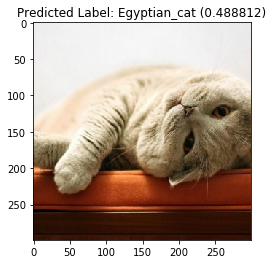

In [5]:
original_img = preprocess_image('lazycat.jpg')

import matplotlib.pyplot as plt
%matplotlib inline
top_predicted_label = inception_v3.decode_predictions(model.predict(original_img), top=1)[0][0]
plt.title('Predicted Label: %s (%f)' % (top_predicted_label[1], top_predicted_label[2]))
plt.imshow(deprocess_image(original_img))

The model classifies this as an Egyptian Cat with 49% certainty.

### Adversarial Learning

Can we change the image to make this classification more certain?

Yes we can!

The trick here is that we look at the model predictions and then "move" the image in the direction that will make it more like the target class (Egyptian Cat).

In [6]:
from keras import losses

# Define the shape of the target
# Inception V3 has 1000 classes
target_class = K.placeholder(shape=(1,1000))

# Our loss is the crossentropy between the predicted class of the
# output and the target class
adversarial_loss = losses.categorical_crossentropy(target_class, model.output)

grads = K.gradients(adversarial_loss, image_shape)[0]

# Clip the grads to prevent blowup
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Define the computation graph in keras
outputs = [adversarial_loss, grads]
fetch_loss_and_grads = K.function([image_shape,target_class], outputs)

# cls is the target class
def eval_loss_and_grads(x,cls, loss_func):
    outs = loss_func([x,cls])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# then we do gradient descent to minimise the loss
def gradient_descent(x, iterations, step, cls=None, max_loss=None, loss_func=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x, cls, loss_func)
        if max_loss is not None and loss_value > max_loss:
            break
        x -= step * grad_values
    return x

W0123 13:36:42.247879 139662202448896 deprecation.py:323] From /nix/store/hijc99lmakqwf7smhlivc0jyy01ihzjb-python3-3.7.5-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The Egyptian Cat is class number 285. See https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a for a complete list

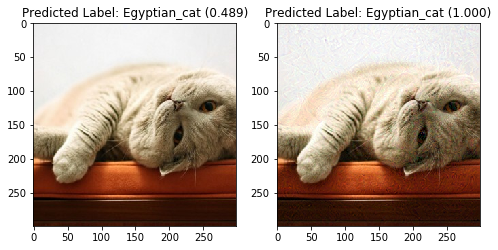

In [7]:
e_cat = np.zeros(shape=(1,1000))
e_cat[0,285] = 1.

def optimise_image(input_path, 
                   target,
                   iterations = 10,
                   step = 0.01,
                   max_loss = 10
                  ):
    # Now do the gradient descent
    original_img = preprocess_image(input_path)
    img_copy = np.copy(original_img)
    newimg = gradient_descent(img_copy,
                              iterations=iterations,
                              step=step,
                              max_loss=max_loss,
                              loss_func = fetch_loss_and_grads,
                              cls = target
                             )
    f, axs= plt.subplots(1,2, figsize=(8,10))
    top_predicted_label = inception_v3.decode_predictions(model.predict(original_img), top=1)[0][0]
    axs[0].set_title('Predicted Label: %s (%.3f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[0].imshow(deprocess_image(original_img))
    top_predicted_label = inception_v3.decode_predictions(model.predict(newimg), top=1)[0][0]
    axs[1].set_title('Predicted Label: %s (%.3f)' % (top_predicted_label[1], top_predicted_label[2]))
    axs[1].imshow(deprocess_image(newimg))
    
optimise_image('lazycat.jpg', e_cat)

100% chance of being an Egyptian Cat!

We can also optimise in other directions

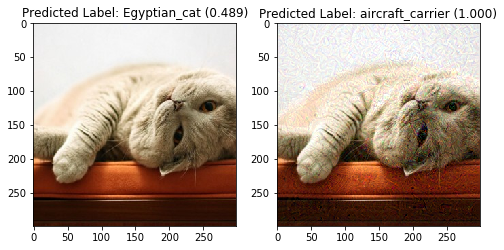

In [8]:
aircraft_carrier = np.zeros(shape=(1,1000))
aircraft_carrier[0,403] = 1.

optimise_image('lazycat.jpg', aircraft_carrier, iterations=100)

So we can make a cat look like an aircraft carrier if we want to!

### The Cat Engine

I have a dataset of 10,000 cat images (from https://www.datainnovation.org/2014/08/10000-cat-pictures-for-science/). We can rank them by how much like a cat they look like.

There are five different types of cat in the classification; just add these together to make the total cat score.

In [2]:
import glob
from tqdm import tqdm
import pickle
import os.path

# Cache the results because this takes a while.
# If the cache file exists then just use this.
if os.path.isfile("cat_probs.pkl"):
    f = open("cat_probs.pkl",'rb')
    cat_probs = pickle.load(f)
    f.close()
else:
    files = glob.glob("CAT_*/*.jpg")
    cat_probs = []
    for f in tqdm(files):
        img = preprocess_image(f)
        preds = model.predict(img)
        tabby = preds[0][281] #281 = tabby cat
        tiger = preds[0][282] #tiger cat
        persian = preds[0][283]
        siamese = preds[0][284]
        egyptian = preds[0][285]
        total = tabby + tiger + persian + siamese + egyptian
        cat_probs.append({'file':f,
                          'tabby': tabby, 
                          'tiger': tiger, 
                          'persian': persian, 
                          'siamese': siamese, 
                          'egyptian': egyptian,
                          'total': total
                         })
    f = open("cat_probs.pkl",'wb')
    pickle.dump(cat_probs,f)
    f.close()


Now we can find the top and bottom images which are the most and least cat like from our data set.

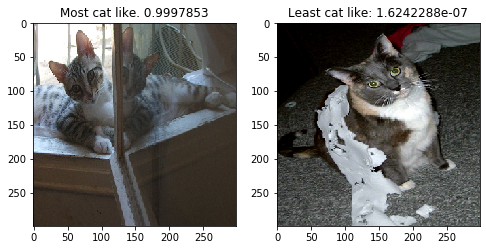

In [10]:
cat_probs = sorted(cat_probs, key=lambda k: k['total'])

f, axs= plt.subplots(1,2, figsize=(8,10))

top = cat_probs[9996]
bottom = cat_probs[0]

axs[0].set_title('Most cat like. %s' % (top['total']))
axs[0].imshow(deprocess_image(preprocess_image(top['file'])))

axs[1].set_title('Least cat like: %s' % (bottom['total']))
axs[1].imshow(deprocess_image(preprocess_image(bottom['file'])))

### Optimising an Image

Let's optimise the bottom image (on the right in the picture above).

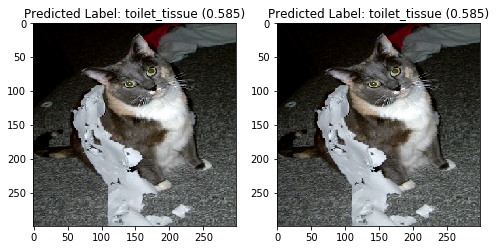

In [11]:
optimise_image(bottom['file'], e_cat, iterations=100, max_loss=None)

It hasn't worked at all! Although the classification as "toilet tissue" does make sense!

Let's figure out what has gone wrong by digging a bit deeper and checking out the gradient at the starting point.

In [12]:
original_img = preprocess_image(bottom['file'])
eval_loss_and_grads(original_img,e_cat, fetch_loss_and_grads)[1]

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

It looks like the gradient is zero to start with. I guess this means our image is maximally un-cat like in some sense.

This seems like it should never happen; I think there always be a way to make things more or less cat-like. In this case the gradient descent gets "stuck" before it even starts. I'm going to modify it so that if the gradient is zero to start with then we'll move to a random image close to our starting point and try again.

In [13]:
def gradient_descent(x, iterations, step, cls=None, max_loss=None, loss_func=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x, cls, loss_func)
        if max_loss is not None and loss_value > max_loss:
            break
        if (np.count_nonzero(grad_values)==0):
            if(i < 1):
                print("0 grad at iter "+str(i))
                grad_values=100*(0.5-np.random.rand(1, 299, 299, 3))
        x -= step * grad_values
    return x

0 grad at iter 0


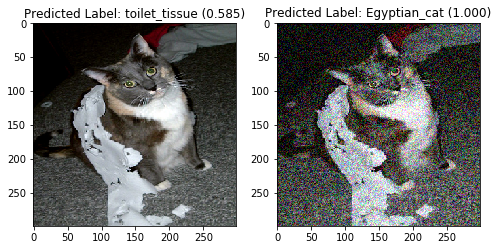

In [14]:
optimise_image(bottom['file'], e_cat, iterations=100, max_loss=None)

There we go! From the least cat-like image to the most cat like.

Of course, this is kind of an unrealistic example because it involves using the gradient of the model's predictions to optimise the image. In real life SEO, no one knows the gradient of the algorithm. Can we treat the classification algorithm as a black box but still optimise the images to make them more cat like?

The answer is (mostly) yes. 

### Optimising without the gradient

One way to do it is with a "single pixel attack". I will modify the example from https://github.com/Hyperparticle/one-pixel-attack-keras/blob/master/1_one-pixel-attack-cifar10.ipynb to demonstrate this.

First we make a function that changes a specific pixel within the image

In [15]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

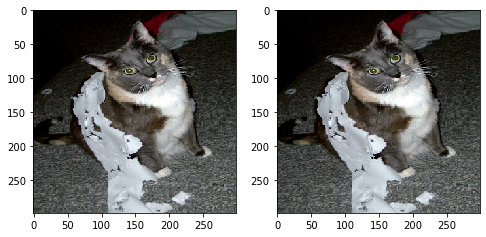

In [16]:
original_img = preprocess_image(bottom['file'])
pixel = np.array([150, 150, 0, 0, 255]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, original_img)[0]

f, axs= plt.subplots(1,2, figsize=(8,10))
axs[0].imshow(deprocess_image(original_img))
axs[1].imshow(deprocess_image(np.array([image_perturbed])))

These look pretty much identical (as you'd expect from only changing one pixel).

Zoom in to see the difference

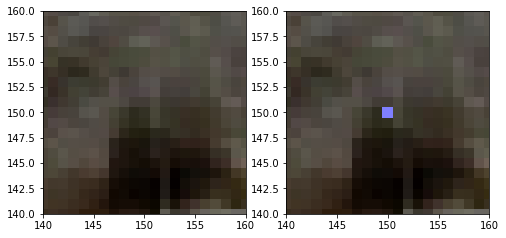

In [17]:
original_img = preprocess_image(bottom['file'])
f, axs= plt.subplots(1,2, figsize=(8,10))
axs[0].set_xlim(140,160)
axs[0].set_ylim(140,160)
axs[1].set_xlim(140,160)
axs[1].set_ylim(140,160)
axs[0].imshow(deprocess_image(original_img))
axs[1].imshow(deprocess_image(np.array([image_perturbed])))

Next we need some functions to get the new "cat score" from a perturbed image

In [18]:
def cat_score(preds):
    tabby = preds[0][281] #281 = tabby cat
    tiger = preds[0][282] #tiger cat
    persian = preds[0][283]
    siamese = preds[0][284]
    egyptian = preds[0][285]
    score = tabby + tiger + persian + siamese + egyptian
    return score
    
def get_new_score(xs, img, get_score, model):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)
    score = get_score(predictions)
    # Return 1-score because we need something to minimise
    return 1 - score

get_new_score(pixel, original_img, cat_score, model)

0.9977246371563524

The `attack_success` function returns True when the cat score is greater than a given threshold

In [19]:
def attack_success(x, img, get_score, threshold, model, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)
    preds = model.predict(attack_image)
    score = get_score(preds)
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Score:', score)
    if (score>threshold):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

attack_success(pixel, original_img, cat_score, 0.001, model, verbose=True)

Score: 0.0022753628


True

Finally we use "differential evolution" to look for a pixel that will increase the score beyond the threshold. Differential evolution is a genetic algorithm; you can read more about it in the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html)

In [28]:
from scipy.optimize import differential_evolution

def attack(img, model, threshold, pixel_count=1,
           maxiter=75, popsize=400, verbose=False):
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,299), (0,299), (0,255), (0,255), (0,255)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return get_new_score(xs, img, cat_score, model)
    
    def callback_fn(x, convergence):
        return attack_success(x, img, cat_score, threshold, model,verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    #Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, img)
    old_preds = model.predict(img)
    old_score = cat_score(old_preds)
    new_preds = model.predict(attack_image)
    new_score = cat_score(new_preds)

    return {'attack': attack_result, 
            'attacked_image': attack_image[0],
            'original_image': img,
            'original_score': old_score,
            'new_score': new_score,
            'improvement': new_score-old_score
           }


original_img = preprocess_image(bottom['file'])

result = attack(original_img, model, 0.5, pixel_count=1, verbose=True)

Score: 0.30088153


We have found an image with a much improved score just by changing one pixel.

To prove only one pixel has been changed, count how many pixels match

In [29]:
matches = result['original_image'][0] == result['attacked_image']
np.size(matches) - np.count_nonzero(matches)

3

3 means only 1 pixel has been changed (RGB values all different = 3 differences in total)

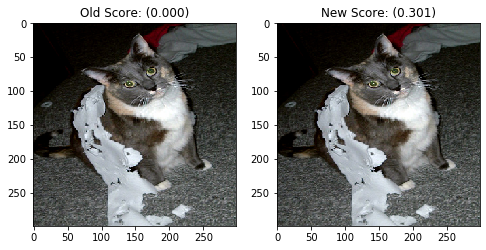

In [30]:
f, axs= plt.subplots(1,2, figsize=(8,10))
axs[0].set_title('Old Score: (%.3f)' % (result['original_score']))
axs[0].imshow(deprocess_image(result['original_image']))
axs[1].set_title('New Score: (%.3f)' % (result['new_score']))
axs[1].imshow(deprocess_image(np.array([result['attacked_image']])))

These look identical. But if we zoom in, we can see the one pixel.

First, see where the attack is taking place:

In [31]:
result['attack'].x

array([253.72261902, 195.03370206, 107.84746137,  17.4547138 ,
       113.47190719])

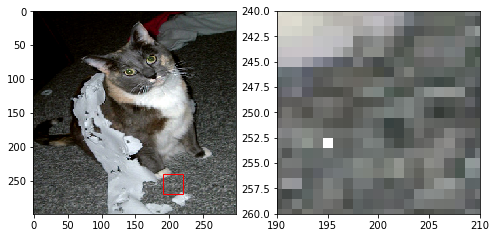

In [32]:
import matplotlib.patches as patches

x = deprocess_image(np.array([result['attacked_image']]))
f, axs= plt.subplots(1,2, figsize=(8,10))
axs[0].add_patch(patches.Rectangle((190,240),30,30,linewidth=1,edgecolor='r',facecolor='none'))
axs[1].set_xlim(190,210)
axs[1].set_ylim(260,240)
axs[0].imshow(x)
axs[1].imshow(x)

We can find a one pixel change that improves that cat score by quite a large amount.

Can we improve it enough to rank in the top ten most cat-like cats?

In [25]:
target_score = cat_probs[-10:][0]['total']

original_img = preprocess_image(bottom['file'])

result = attack(original_img, 
                model, 
                target_score, 
                pixel_count=3 # increase pixel count to make it more likely to find a good solution
               )
result['new_score']

0.65071476

Unfortunately this is not good enough to get into the top ten

In [5]:
new_ranking = sum([0.782 > x['total'] for x in cat_probs])
len(cat_probs)

9997

But an improvement in ranking of 4000 places is something! Although perhaps our cat engine is like a search engine and any improvement doesn't really mean much until you get in the top ten.

### Optimising without the score

Again, real life SEO is harder than our toy example because nobody has access to their ranking "score". Instead the only thing you can observe is your ranking in the search engine results. Even ignoring personalisation and localisation this is still a much harder task. You could increase your ranking score (i.e. you are moving in the right direction) but you don't even realise unless your score increases above the site ranking one place above you.

We can change the `get_new_score` function to return the ranking rather than the score

In [27]:
def cat_rank_score(preds):
    tabby = preds[0][281] #281 = tabby cat
    tiger = preds[0][282] #tiger cat
    persian = preds[0][283]
    siamese = preds[0][284]
    egyptian = preds[0][285]
    score = tabby + tiger + persian + siamese + egyptian
    new_ranking = sum([score > x['total'] for x in cat_probs])
    return new_ranking
    
def get_new_score(xs, img, get_score, model):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)
    score = get_score(predictions)
    # Return 1-score because we need something to minimise
    return (9997-score)

def attack(img, model, threshold, pixel_count=1,
           maxiter=75, popsize=400, verbose=False):
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,299), (0,299), (0,255), (0,255), (0,255)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return get_new_score(xs, img, cat_rank_score, model)
    
    def callback_fn(x, convergence):
        return attack_success(x, img, cat_rank_score, threshold, model,verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    #Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, img)
    old_preds = model.predict(img)
    old_score = cat_score(old_preds)
    new_preds = model.predict(attack_image)
    new_score = cat_score(new_preds)

    return {'attack': attack_result, 
            'attacked_image': attack_image[0],
            'original_image': img,
            'original_score': old_score,
            'new_score': new_score,
            'improvement': new_score-old_score
           }


original_img = preprocess_image(bottom['file'])

result = attack(original_img, model, 5000, pixel_count=1)

new_ranking = sum([result['new_score'] > x['total'] for x in cat_probs])
new_ranking

5079

Which is better than the result from the previous method!

This must be because of the stochastic nature of differential evolution.

### Conclusion

All you need to do is pick a webpage, change one element (DOM element? Character in the HTML?) at a time and watch the ranking results. Use differential evolution to pick and change the element and, eventually, improved rankings will flow your way.

I can't believe I'm giving this away for free ;-)